In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '6, 7, 8, 9, ' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

def generate_noise_fixed(key, N_particles):
    """Generate fixed noise for reproducible results"""
    keys = random.split(key, 6)
    noise = jnp.column_stack([
        random.uniform(keys[0], shape=(N_particles,)),  # r
        random.uniform(keys[1], shape=(N_particles,)),  # phi
        random.uniform(keys[2], shape=(N_particles,)),  # sin_i  
        random.uniform(keys[3], shape=(N_particles,)),  # u
        random.uniform(keys[4], shape=(N_particles,)),  # phi_v
        random.uniform(keys[5], shape=(N_particles,))   # sin_i_v
    ])
    return noise


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)



In [3]:

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

KeyboardInterrupt: 

In [ ]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

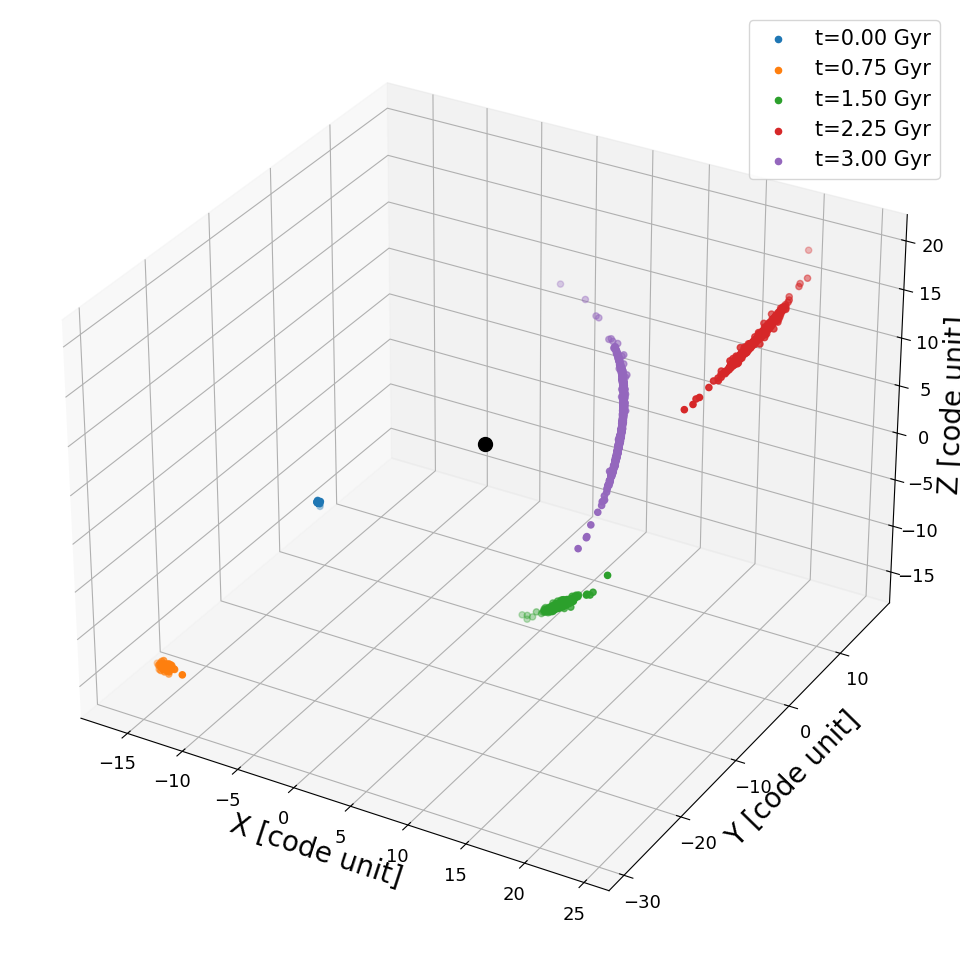

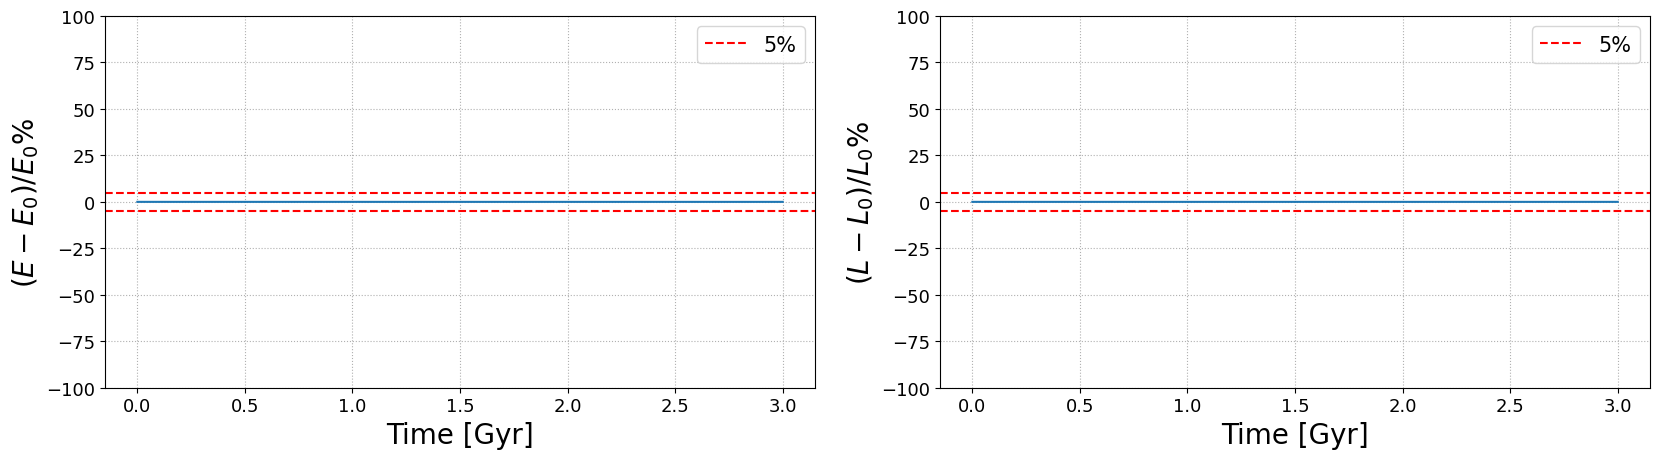

In [ ]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


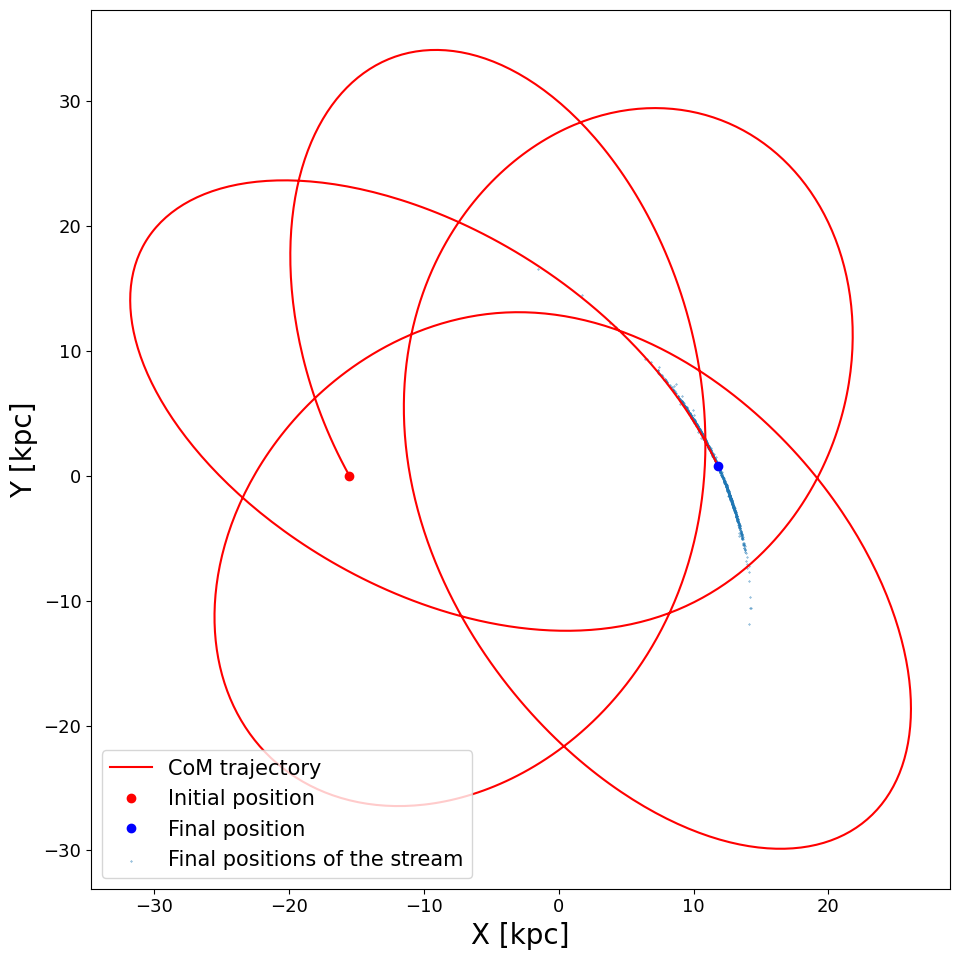

In [ ]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

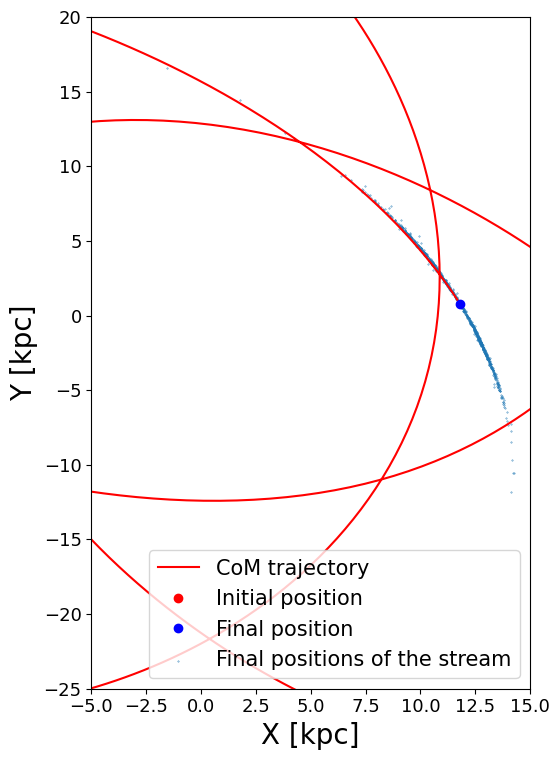

In [ ]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

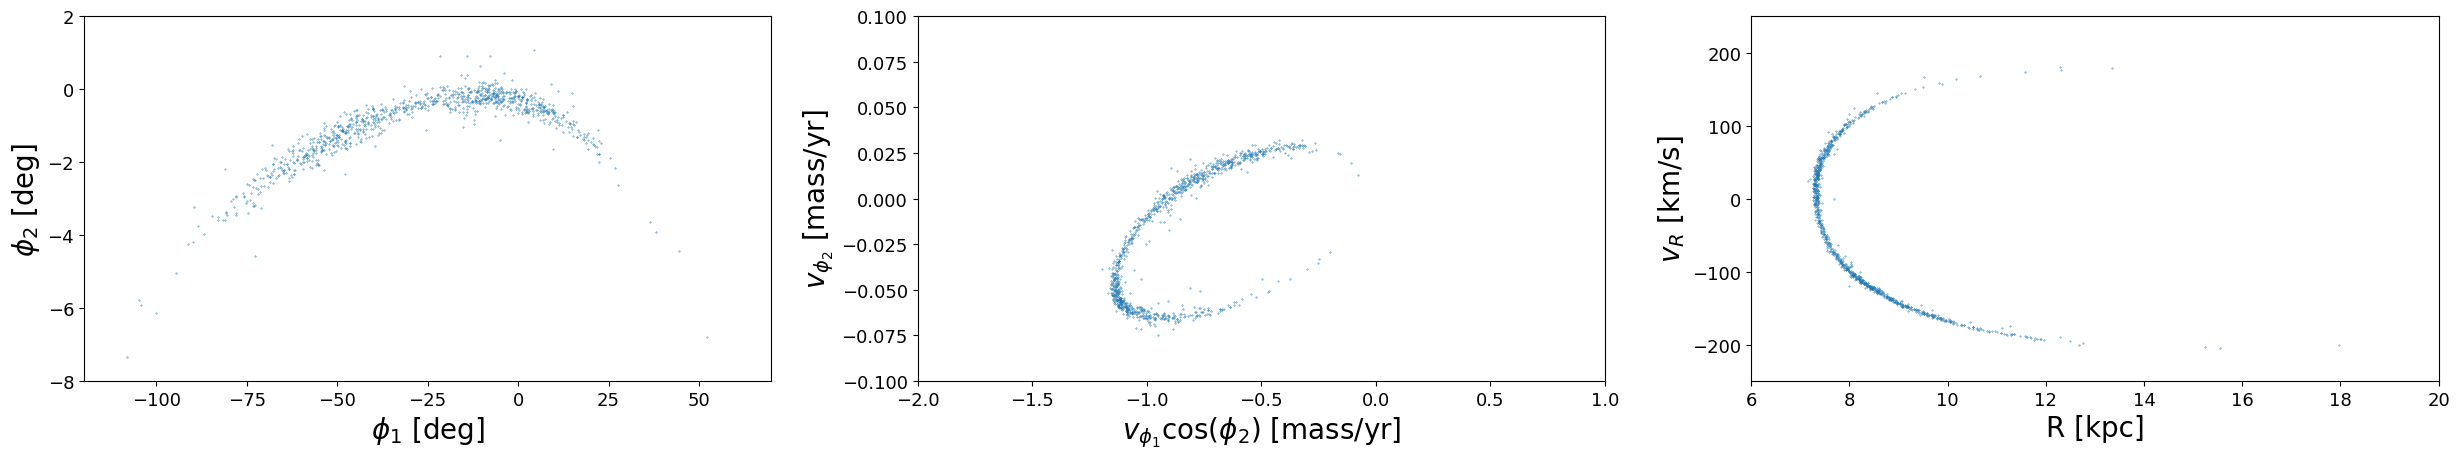

In [9]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_3321435/1384333403.py:28: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_3321435/1384333403.py:38: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_3321435/1384333403.py:47: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


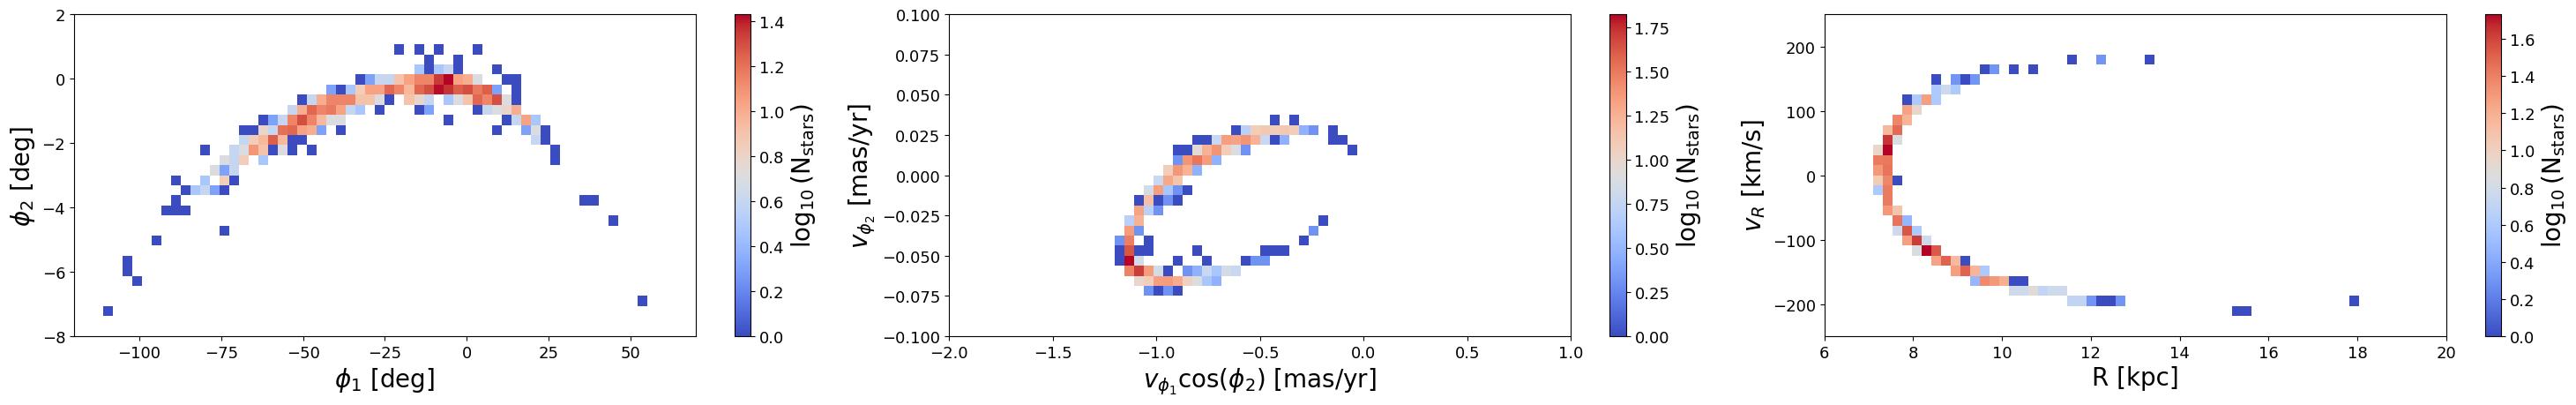

In [10]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# phi1_bins = jnp.linspace(-120, 70, 129)    # 64 bins
# phi2_bins = jnp.linspace(-8, 2, 129)       # 32 bins
# v1_bins = jnp.linspace(-2., 1.0, 129)      # 64 bins  
# v2_bins = jnp.linspace(-0.10, 0.10, 129)   # 32 bins
# R_bins = jnp.linspace(6, 20, 129)          # 64 bins
# vR_bins = jnp.linspace(-250, 250, 129)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

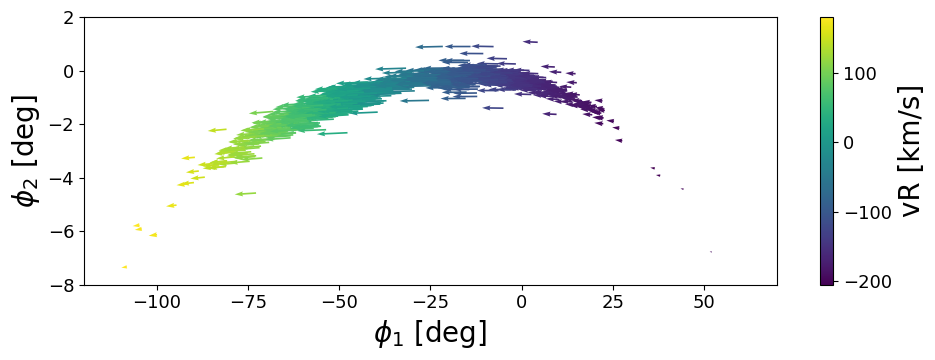

In [11]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

In [12]:
stream_target = s

In [13]:
final_state_target = final_state.copy()
final_state_target = final_state_target.reshape(-1, 6)

In [14]:
stream_target.shape

(1000, 6)

In [15]:
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 1e-3])  #R, phi1, phi2, vR, v1, v2

jnp.expand_dims(noise_std, axis=0).repeat(stream_target.shape[0], axis=0)

Array([[2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       ...,
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03],
       [2.5e-01, 1.0e-03, 1.5e-01, 5.0e+00, 1.0e-01, 1.0e-03]],      dtype=float32)

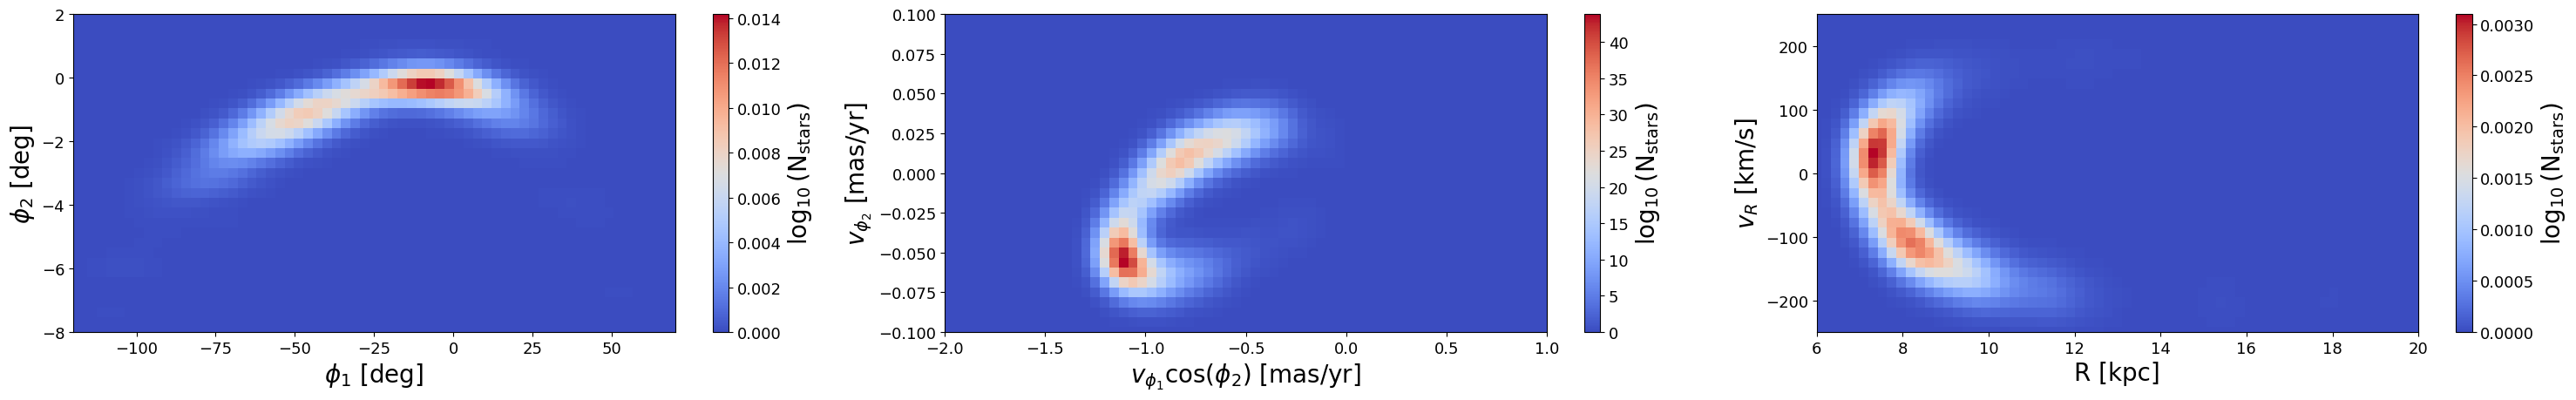

In [16]:
from jax.scipy.special import logsumexp

@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens


x_phi = stream_target[:, [1,2]]   # phi1, phi2
x_v   = stream_target[:, [4,5]]   # vphi1, vphi2
x_R   = stream_target[:, [0,3]]   # R, v_radial

def compute_optimal_bandwidths(stream_target):
    """
    Compute optimal bandwidths using Silverman's rule and data characteristics
    """
    # Extract different coordinate pairs
    phi_data = stream_target[:, [1, 2]]  # phi1, phi2
    v_data = stream_target[:, [4, 5]]    # v1_cosphi2, v2
    R_data = stream_target[:, [0, 3]]    # R, vR
    
    def silverman_bandwidth_2d(data):
        """Silverman's rule for 2D data"""
        n = data.shape[0]
        cov_matrix = jnp.cov(data.T)
        # For 2D: h_i = (4/(d+2))^(1/(d+4)) * n^(-1/(d+4)) * sigma_i
        # where d=2, so (4/4)^(1/6) * n^(-1/6) = n^(-1/6)
        factor = jnp.power(n, -1/6)
        return factor * jnp.sqrt(jnp.diag(cov_matrix))
    
    bw_phi = silverman_bandwidth_2d(phi_data)
    bw_v = silverman_bandwidth_2d(v_data) 
    bw_R = silverman_bandwidth_2d(R_data)
    
    return bw_phi, bw_v, bw_R

# Compute optimal bandwidths
bw_phi, bw_v, bw_R = compute_optimal_bandwidths(stream_target)

# choose bandwidths (tune or use Silverman's rule)
# bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
# bw_v   = jnp.array([0.1, 0.01])    # example velocities
# bw_R   = jnp.array([0.5, 20.0])    # example R and vR

# KDE densities on each meshgrid
dens_phi_target = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
dens_v_target   = kde2d_on_grid(x_v, V1, V2, bw_v)
dens_R_target   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

fig = plt.figure(figsize=(30, 5), tight_layout=True)
# Create 2D histograms
ax = fig.add_subplot(131)
im1 = ax.pcolormesh(PHI1, PHI2, dens_phi_target, cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
im2 = ax.pcolormesh(V1, V2, dens_v_target, cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
im3 = ax.pcolormesh(R_GRID, VR_GRID, dens_R_target, cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

# Parameters

# NFW Mass

In [17]:
from jax.scipy.special import logsumexp

# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1_000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

# @jit
def time_integration_NFW_mass_grad(Mvir, key ):

    Mvir = 10**Mvir
    Mvir = Mvir * u.Msun.to(code_units.code_mass)
    

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(1)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # bw_phi, bw_v, bw_R = compute_optimal_bandwidths(stream)

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return jnp.exp(-0.1 * (
            loss_js(dens_phi_target, dens_phi) 
            +
            loss_js(dens_v_target, dens_v) 
            + 
            loss_js(dens_R_target, dens_R)
            )
            )




# Utility: ensure non-neg and avoid zeros
@jit
def _safe(d, eps=1e-12):
    return jnp.clip(d, a_min=eps)


@jit
def loss_js(d_target, d_sim):
    p = _safe(d_target) / jnp.sum(_safe(d_target))
    q = _safe(d_sim)   / jnp.sum(_safe(d_sim))
    m = 0.5 * (p + q)
    return 0.5 * (jnp.sum(p * (jnp.log(p) - jnp.log(m))) + jnp.sum(q * (jnp.log(q) - jnp.log(m))))


@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens

    
   


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = jnp.log10(params.NFW_params.Mvir*(3/4))
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
# test = check_grads(time_integration_NFW_mass_grad, jnp.array([Mvir]), order=3)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 5.0045674e-06
Loss:
 0.89389217


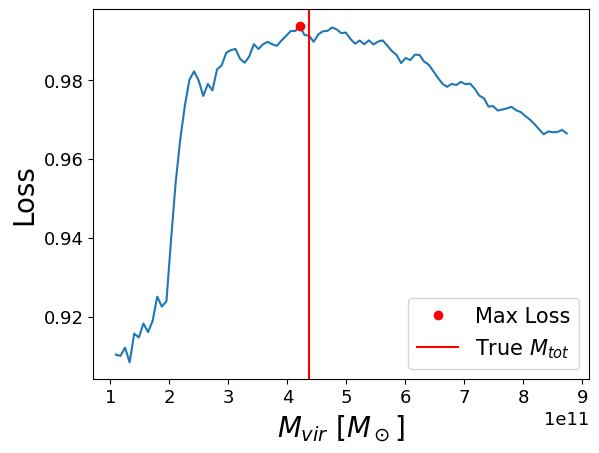

In [18]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(2.), n_sim) * code_units.code_mass.to(u.Msun)
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)])])  # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))

Mvir_sharded = jax.lax.with_sharding_constraint(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.lax.with_sharding_constraint(keys, NamedSharding(mesh, PartitionSpec("i")))
# Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))


Mvir_sharded = jnp.log10(Mvir_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded), 
    batch_size=3
)



plt.figure()
plt.plot(Mvir, loss)
plt.plot(Mvir[jnp.argmax(loss)], loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

(array([ 4., 22., 50., 16.,  3.,  1.,  1.,  0.,  1.,  2.]),
 array([-1.57766283, -0.77580047,  0.02606189,  0.82792437,  1.62978661,
         2.43164873,  3.23351145,  4.03537369,  4.83723593,  5.63909817,
         6.44096088]),
 <BarContainer object of 10 artists>)

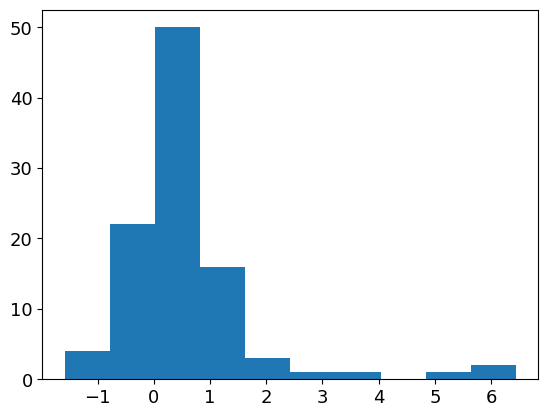

In [19]:
plt.hist(grad)

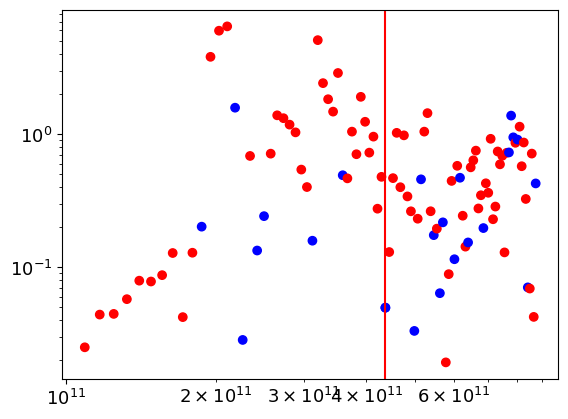

In [20]:
plt.scatter(Mvir, jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

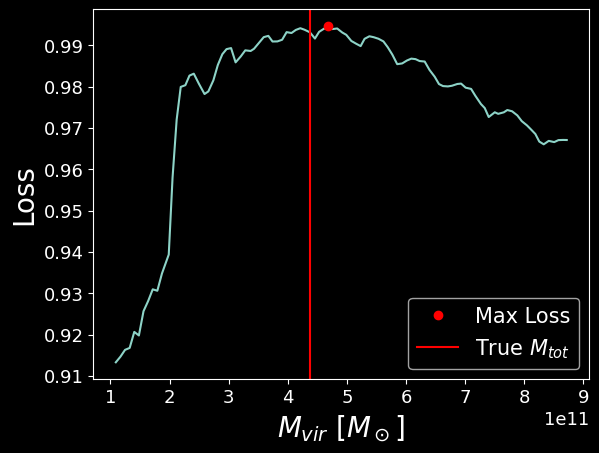

In [27]:
n_round = 3
for i in range(n_round):
    Mvir_grad_descend = Mvir_sharded + 1e-3 * grad

    loss_new, grad_new = jax.lax.map(
        time_integration_NFW_mass_grad_map, 
        (Mvir_grad_descend, keys_sharded), 
        batch_size=12
    )

plt.figure()
plt.plot(10**Mvir_grad_descend*(code_units.code_mass).to(u.Msun), loss_new)
plt.plot(10**Mvir_grad_descend[jnp.argmax(loss_new)]*(code_units.code_mass).to(u.Msun), loss_new[jnp.argmax(loss_new)], 'ro', label='Max Loss')
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()

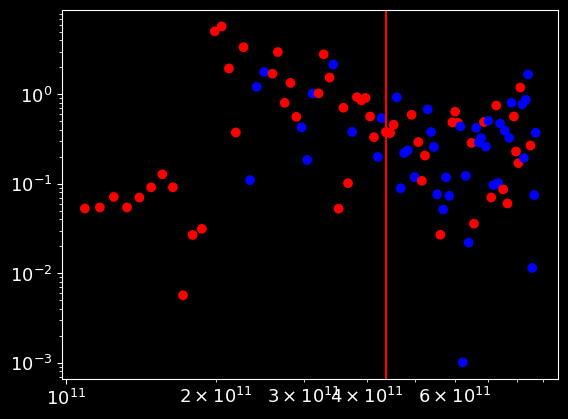

In [28]:
plt.scatter(10**Mvir_grad_descend*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad_new**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

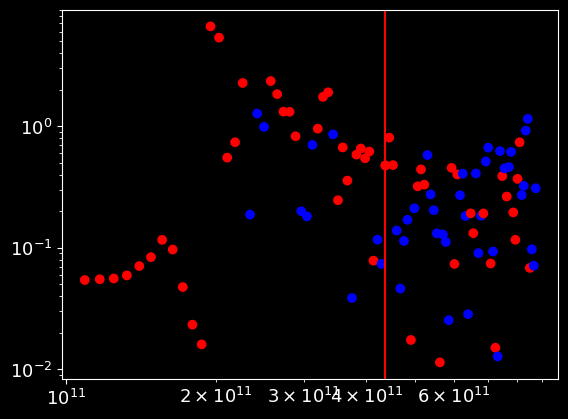

In [29]:

plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt((0.5*(grad_new + grad))**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

## MVir averaging over samples

In [ ]:
from jax.scipy.special import logsumexp

# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 5000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

# @jit
def time_integration_NFW_mass_grad(Mvir, key ):

    Mvir = 10**Mvir
    

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    key_noise1, key_noise2 = random.split(key_noise)

    stream1 = stream + jax.random.normal(key_noise1, shape=stream.shape) * noise_std
    stream2 = stream + jax.random.normal(key_noise2, shape=stream.shape) * noise_std

    print(stream1.shape)
    

    return jnp.mean(jnp.array([produce_loss_densities(stream1), produce_loss_densities(stream2)]), axis=0)
    
    

    # return jnp.exp(-0.1 * (loss_js(dens_phi_target, dens_phi) +
    #         loss_js(dens_v_target, dens_v) +
    #         loss_js(dens_R_target, dens_R)))



@jit
def produce_loss_densities(stream):
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    return (jnp.sum((dens_phi - dens_phi_target)**2) +
            jnp.sum((dens_v - dens_v_target)**2) +
            jnp.sum((dens_R - dens_R_target)**2))

# Utility: ensure non-neg and avoid zeros
@jit
def _safe(d, eps=1e-12):
    return jnp.clip(d, a_min=eps)


@jit
def loss_js(d_target, d_sim):
    p = _safe(d_target) / jnp.sum(_safe(d_target))
    q = _safe(d_sim)   / jnp.sum(_safe(d_sim))
    m = 0.5 * (p + q)
    return 0.5 * (jnp.sum(p * (jnp.log(p) - jnp.log(m))) + jnp.sum(q * (jnp.log(q) - jnp.log(m))))


@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens

    
   


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = jnp.log10(params.NFW_params.Mvir*(3/4))
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
# test = check_grads(time_integration_NFW_mass_grad, jnp.array([Mvir]), order=3)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

(1000, 6)
Gradient of the total mass of the Mvir of NFW:
 -1295129.5
Loss:
 10544.372


(1000, 6)
(1000, 6)


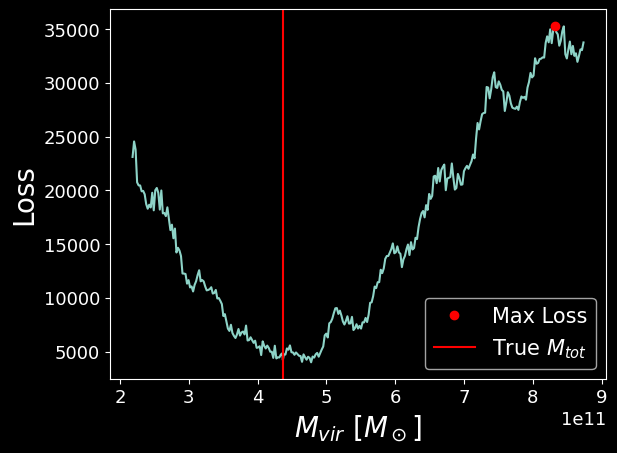

In [18]:
n_sim = 299
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(0.50), params.NFW_params.Mvir*(2.), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mvir_sharded = jnp.log10(Mvir_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded), 
    batch_size=4
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.plot(Mvir[jnp.argmax(loss)]*(code_units.code_mass).to(u.Msun), loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

(array([  2.,  16.,  24.,  44., 109.,  76.,  22.,   6.,   0.,   1.]),
 array([-4754285.5 , -3824384.25, -2894483.  , -1964581.5 , -1034680.25,
         -104779.  ,   825122.5 ,  1755023.5 ,  2684925.  ,  3614826.5 ,
         4544727.5 ]),
 <BarContainer object of 10 artists>)

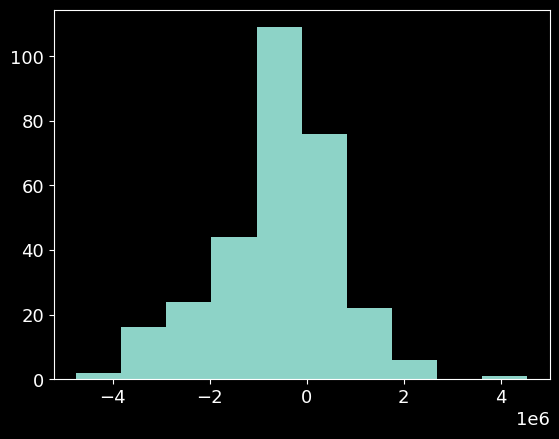

In [19]:
plt.hist(grad)

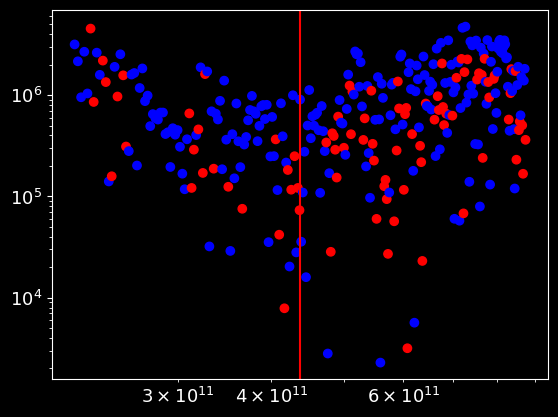

In [20]:
plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

## NFW_r_s

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                          integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         diffrax_solver = TSIT5,)
config_com = config_com._replace(return_snapshots=False,
                                  integrator = DIFFRAX_BACKEND,
                                  fixed_timestep = False,
                                  diffrax_solver = TSIT5,)

@jit
def time_integration_NFW_r_s_grad(r_s, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    r_s=r_s 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    r_s=r_s 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
r_s = params.NFW_params.r_s*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_r_s_grad, )(r_s, key)
print("Gradient of the total mass of the r_s of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the r_s of NFW:
 -0.22601509
Loss:
 -0.049773384


In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_s = np.linspace(params.NFW_params.r_s*(1/4), params.NFW_params.r_s*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
r_s = np.concatenate([r_s, np.array([params.NFW_params.r_s])]) # Append the true Mvir value
r_s = jnp.array(np.sort(r_s))

mesh = Mesh(np.array(jax.devices()), ("i",))
r_s_sharded = jax.device_put(r_s, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_r_s_grad_map(r_s_and_key):
    r_s, key = r_s_and_key
    return jax.value_and_grad(time_integration_NFW_r_s_grad)(r_s, key)

loss, grad = jax.lax.map(
    time_integration_NFW_r_s_grad_map, 
    (r_s_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(r_s_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.NFW_params.r_s*(code_units.code_length).to(u.kpc), color='r', label='True $r_{s}$')
plt.xlabel("$NFW_{r_s}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_rs.pdf')

NameError: name 'time_integration_NFW_r_s_grad' is not defined

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  2., 87.,  8.,  1.]),
 array([-245.17704773, -213.49264526, -181.80822754, -150.12382507,
        -118.43942261,  -86.75502014,  -55.07060242,  -23.38619995,
           8.29820251,   39.98262024,   71.66701508]),
 <BarContainer object of 10 artists>)

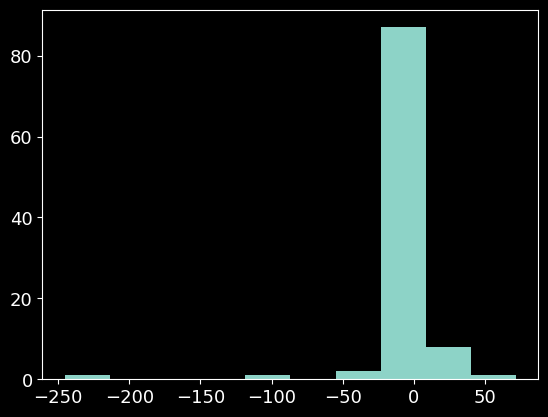

In [ ]:
plt.hist(grad)

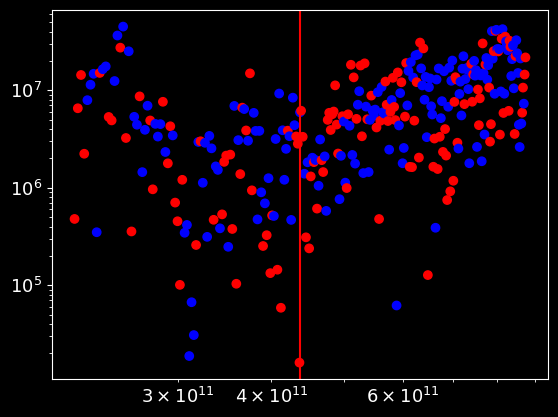

In [26]:
plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

# Miamoto Nagai Parameters

# Mass of MN

In [92]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_M_grad(M, key):

    M = 10**M

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return jnp.exp(-0.1 * (loss_js(dens_phi_target, dens_phi) +
            loss_js(dens_v_target, dens_v) +
            loss_js(dens_R_target, dens_R)))


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.MN_params.M*(3/4) 
M = jnp.log10(M)
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_M_grad, )(M, key)
print("Gradient of the total mass of the M of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the M of MN:
 0.069918476
Loss:
 0.9933715


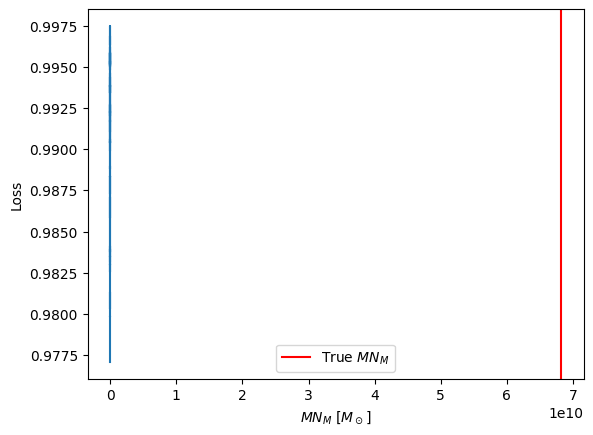

In [93]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.MN_params.M*(1/4), params.MN_params.M*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.MN_params.M])]) # Append the true Mvir value
M = jnp.array(np.sort(M))


mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
M_sharded = jnp.log10(M_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_MN_M_grad)(M, key)

loss, grad = jax.lax.map(
    time_integration_MN_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.MN_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $MN_{M}$')
plt.xlabel("$MN_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_MN_mass.pdf')

(array([ 3.,  1.,  4., 31., 36., 14.,  4.,  1.,  4.,  2.]),
 array([-1.65924323, -1.25571299, -0.85218287, -0.44865263, -0.0451225 ,
         0.35840762,  0.76193798,  1.1654681 ,  1.56899822,  1.97252834,
         2.37605858]),
 <BarContainer object of 10 artists>)

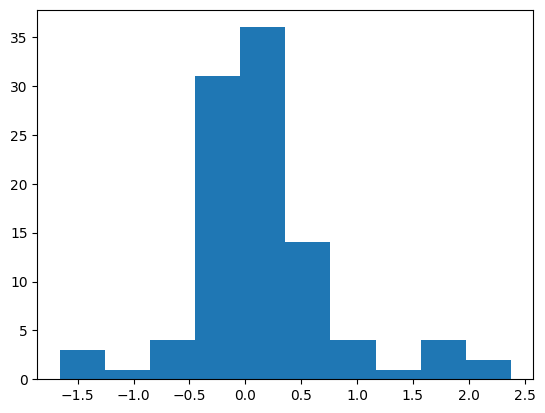

In [94]:
plt.hist(grad)

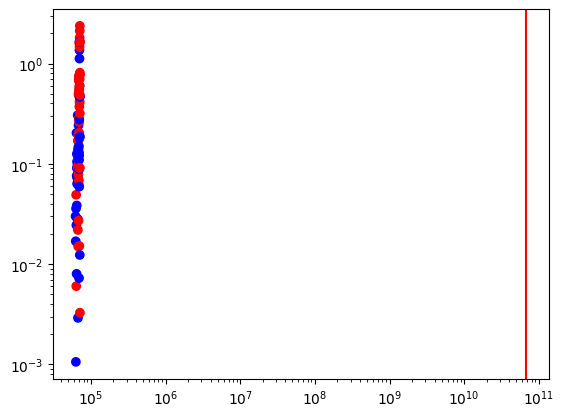

In [95]:
plt.scatter(M_sharded*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.MN_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

# a of MN

In [52]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    a=a 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
a = params.MN_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(a, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 0.2600882
Loss:
 -0.030842813


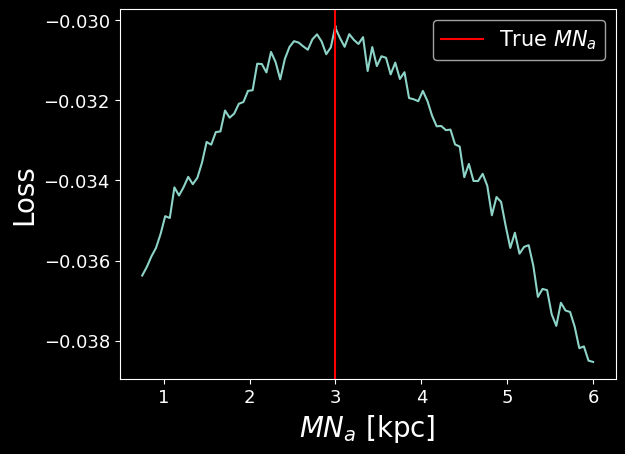

In [53]:
n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.MN_params.a*(1/4), params.MN_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.MN_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

mesh = Mesh(np.array(jax.devices()), ("i",))
a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_MN_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_MN_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{a}$')
plt.xlabel("$MN_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_MN_a.pdf')

(array([ 5.,  2.,  5., 11., 32., 26.,  8.,  4.,  6.,  1.]),
 array([-11.2229948 ,  -8.93947792,  -6.65596199,  -4.37244558,
         -2.08892918,   0.19458675,   2.47810364,   4.76162052,
          7.04513645,   9.32865238,  11.61216927]),
 <BarContainer object of 10 artists>)

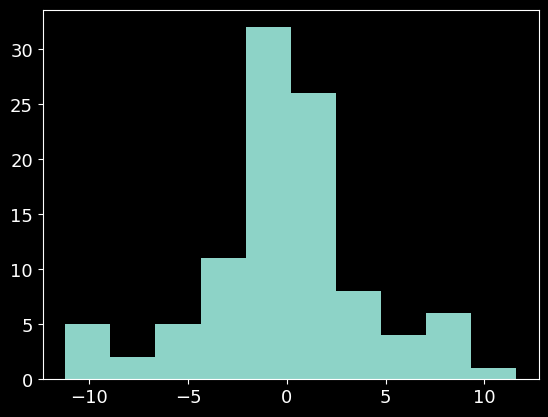

In [54]:
plt.hist(grad)

# b of MN

In [22]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_b_grad(b, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    b=b 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    b=b 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
b = params.MN_params.b*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(b, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 204783.84
Loss:
 -3827.6367


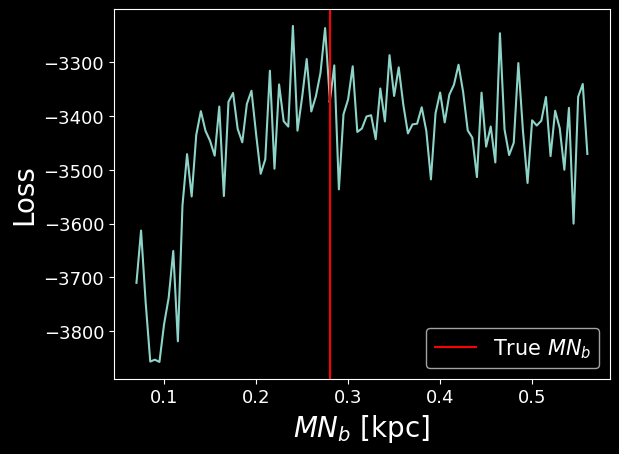

In [23]:
n_sim = 99
keys = jnp.arange(n_sim+1)
b = np.linspace(params.MN_params.b*(1/4), params.MN_params.b*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
b = np.concatenate([b, np.array([params.MN_params.b])]) # Append the true Mvir value
b = jnp.array(np.sort(b))

mesh = Mesh(np.array(jax.devices()), ("i",))
b_sharded = jax.device_put(b, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_b_grad_map(b_and_key):
    b, key = b_and_key
    return jax.value_and_grad(time_integration_MN_b_grad)(b, key)

loss, grad = jax.lax.map(
    time_integration_MN_b_grad_map, 
    (b_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(b_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.b*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{b}$')
plt.xlabel("$MN_{b}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_MN_b.pdf')

# PSP parameters

# M of PSP

In [24]:
config_com = config_com._replace(return_snapshots=False,)
config = config._replace(return_snapshots=False,)

@jit
def time_integration_PSP_M_grad(M, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot])
    #we construmt the initial state of the com  
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]
    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)
    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,) 
    #we calculate the loss as the negative log likelihood of the stream
    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.PSP_params.M*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_M_grad, )(M, key)
print("Gradient of the total mass of the M of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the M of PSP:
 0.1310621
Loss:
 -3467.3672


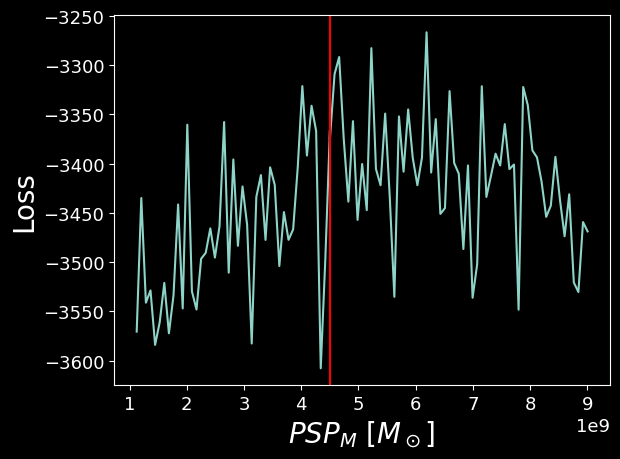

In [25]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.PSP_params.M*(1/4), params.PSP_params.M*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.PSP_params.M])])  # Append the true Mvir value
M = jnp.array(np.sort(M))
mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_PSP_M_grad)(M, key)
loss, grad = jax.lax.map(
    time_integration_PSP_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.PSP_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $PSP_{M}$')
plt.xlabel("$PSP_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.savefig('./loss_landscape/loss_landscape_PSP_mass.pdf')

# alpha of PSP

In [26]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_PSP_alpha_grad(alpha, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    alpha=alpha 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    alpha=alpha 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
alpha = 2.9
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_alpha_grad, )(alpha, key)
print("Gradient of the total mass of the alpha of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the alpha of PSP:
 -78934.36
Loss:
 -3577.2239


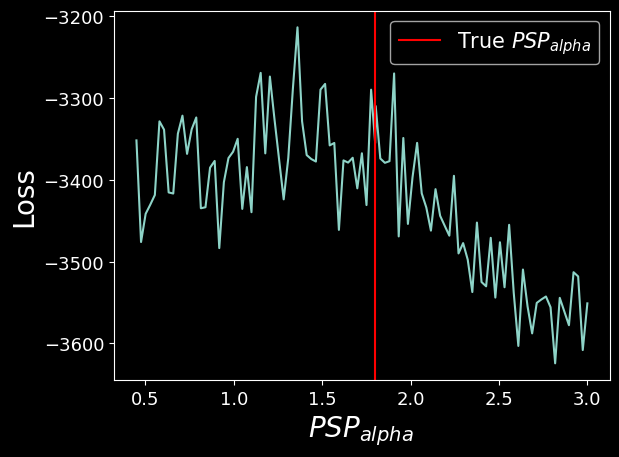

In [27]:
n_sim = 99
keys = jnp.arange(n_sim+1)
alpha = np.linspace(params.PSP_params.alpha*(1/4), 3, n_sim)
# Correct way to append - assign the result back to Mvir
alpha = np.concatenate([alpha, np.array([params.PSP_params.alpha])])  # Append the true Mvir value
alpha = jnp.array(np.sort(alpha))
mesh = Mesh(np.array(jax.devices()), ("i",))
alpha_sharded = jax.device_put(alpha, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_alpha_grad_map(alpha_and_key):
    alpha, key = alpha_and_key
    return jax.value_and_grad(time_integration_PSP_alpha_grad)(alpha, key)
loss, grad = jax.lax.map(
    time_integration_PSP_alpha_grad_map, 
    (alpha_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(alpha_sharded, loss)
plt.axvline(params.PSP_params.alpha, color='r', label='True $PSP_{alpha}$')
plt.xlabel("$PSP_{alpha}$ ")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_PSP_alpha.pdf')

# r_c of PSP

In [28]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit

def time_integration_PSP_r_c_grad(r_c, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    r_c=r_c 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    r_c=r_c 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.sum(logL_values)
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)

# Calculate the value of the function and the gradient wrt the r_c of the PSP
r_c = params.PSP_params.r_c*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_r_c_grad, )(r_c, key)
print("Gradient of the total mass of the r_c of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the r_c of PSP:
 2.838761e-31
Loss:
 -3356.3735


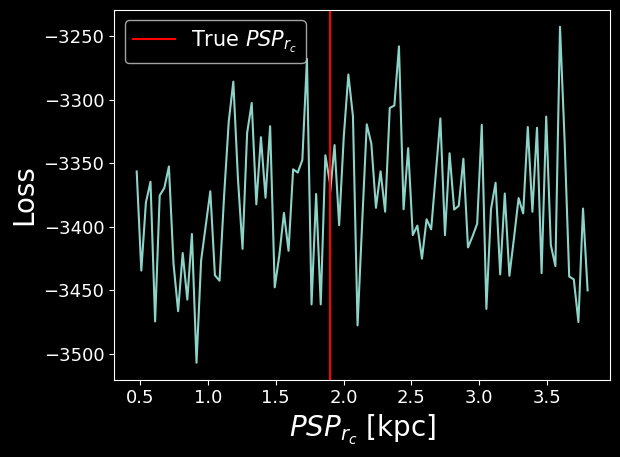

In [29]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_c = np.linspace(params.PSP_params.r_c*(1/4), params.PSP_params.r_c*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
r_c = np.concatenate([r_c, np.array([params.PSP_params.r_c])])  # Append the true Mvir value
r_c = jnp.array(np.sort(r_c))
mesh = Mesh(np.array(jax.devices()), ("i",))
r_c_sharded = jax.device_put(r_c, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_r_c_grad_map(r_c_and_key):
    r_c, key = r_c_and_key
    return jax.value_and_grad(time_integration_PSP_r_c_grad)(r_c, key)
loss, grad = jax.lax.map(
    time_integration_PSP_r_c_grad_map, 
    (r_c_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(r_c_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.PSP_params.r_c*(code_units.code_length).to(u.kpc), color='r', label='True $PSP_{r_c}$')
plt.xlabel("$PSP_{r_c}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_PSP_rc.pdf')

# Combined parameters

## t_end and t_end_vs_NFW_mass

Gradient of the total mass of the t_end:
 7.446213
Loss:
 -0.74056435


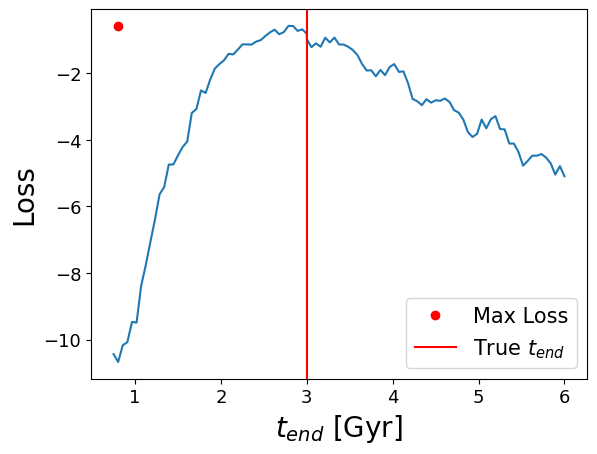

In [27]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 1_000, )
# config_com = config_com._replace(return_snapshots=False,)
config =  config._replace(return_snapshots=False,
                         N_particles = 1_000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                         fixed_timestep = False,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                #  integrator = LEAPFROG,
                                 )
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_tend_grad(t_end, key):
    # t_end = jnp.log10(t_end)

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # bw_phi, bw_v, bw_R = compute_optimal_bandwidths(stream)

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return -10 * (
            loss_js(dens_phi_target, dens_phi) 
            +
            loss_js(dens_v_target, dens_v) 
            + 
            loss_js(dens_R_target, dens_R)
            )
            




# Utility: ensure non-neg and avoid zeros
@jit
def _safe(d, eps=1e-12):
    return jnp.clip(d, a_min=eps)


@jit
def loss_js(d_target, d_sim):
    p = _safe(d_target) / jnp.sum(_safe(d_target))
    q = _safe(d_sim)   / jnp.sum(_safe(d_sim))
    m = 0.5 * (p + q)
    return 0.5 * (jnp.sum(p * (jnp.log(p) - jnp.log(m))) + jnp.sum(q * (jnp.log(q) - jnp.log(m))))


@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end*(0.90)
key = 0
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  
n_sim = 99
keys = jnp.arange(n_sim+1)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(t_end, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# t_end_sharded =  10**t_end_sharded

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=3,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.plot(t_end[jnp.argmin(loss)]*(code_units.code_time).to(u.Gyr), loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$ [Gyr]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


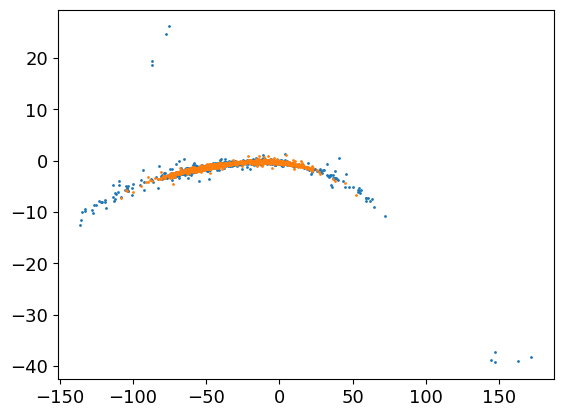

In [35]:

@jit
def time_integration_tend_grad(t_end, key):
    # t_end = jnp.log10(t_end)

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    return stream

stream = time_integration_tend_grad(t_end=params.t_end, key=0)
plt.scatter(stream[:,1], stream[:,2], s=1)
plt.scatter(stream_target[:,1], stream_target[:,2], s=1)

In [33]:
loss[jnp.argmax(loss)]

Array(-0.5814675, dtype=float32)

In [32]:
t_end[jnp.argmax(loss)]

Array(0.9285714, dtype=float32)

(array([ 1.,  0.,  0.,  0.,  0.,  2., 82., 12.,  1.,  2.]),
 array([-3611.60131836, -3071.68261719, -2531.76367188, -1991.84484863,
        -1451.92602539,  -912.00708008,  -372.08837891,   167.83032227,
          707.74926758,  1247.66821289,  1787.58728027]),
 <BarContainer object of 10 artists>)

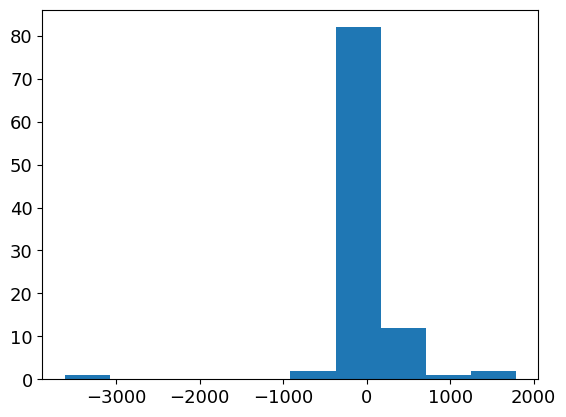

In [28]:
plt.hist(grad)

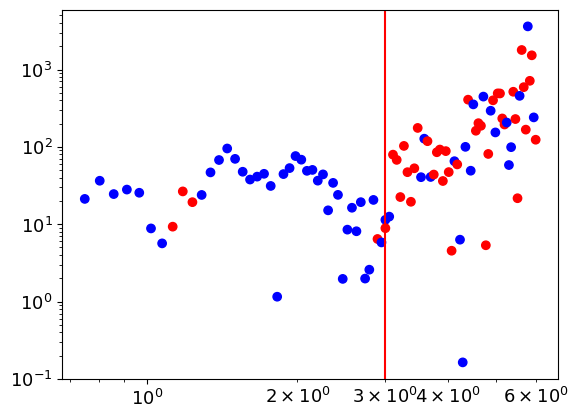

In [29]:
plt.scatter(t_end*(code_units.code_time).to(u.Gyr), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

Gradient of the total mass of the Mvir of NFW:
 (Array(nan, dtype=float32), Array(nan, dtype=float32))
Loss:
 nan


Text(0.5, 1.0, 'loss_landscape')

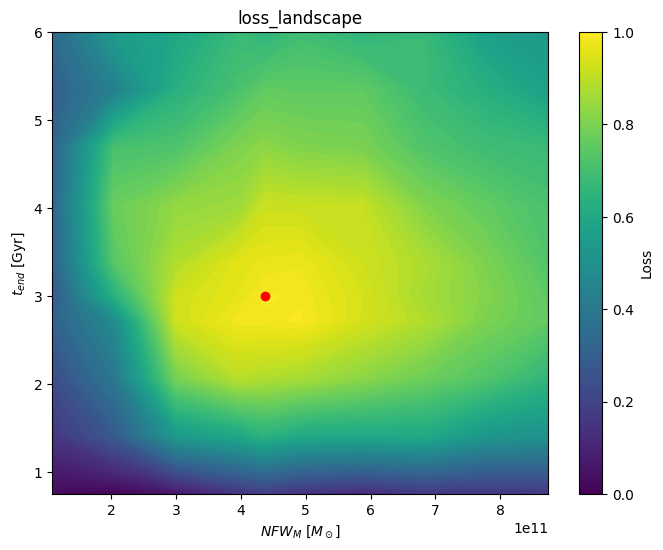

In [83]:
# Gradient on the loss for 2 parameters
# for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,
#                          N_particles = 500, )
# config_com = config_com._replace(return_snapshots=False,)

# config =  config._replace(return_snapshots=False,)
# config_com = config_com._replace(return_snapshots=False,)
from odisseo.option_classes import LEAPFROGMIDPOINT, REVERSIBLEHEUN
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         integrator = DIFFRAX_BACKEND,
                          fixed_timestep = False,
                         diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 integrator = DIFFRAX_BACKEND,
                                 fixed_timestep = False,
                                 diffrax_solver = TSIT5,
                                 )
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_NFWmass_tend_grad(Mvir, t_end, key):

    # t_end = jnp.log10(t_end)
    Mvir = 10**Mvir

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,  # Update the t_end parameter
                )
    
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    
    #we also update the t_end parameter for the center of mass
    new_params_com = new_params_com._replace(
                t_end=-t_end,  # Update the t_end parameter for the center of mass
                )
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return jnp.exp(-0.1 * (loss_js(dens_phi_target, dens_phi) +
            loss_js(dens_v_target, dens_v) +
            loss_js(dens_R_target, dens_R)))
    

# Utility: ensure non-neg and avoid zeros
@jit
def _safe(d, eps=1e-12):
    return jnp.clip(d, a_min=eps)


@jit
def loss_js(d_target, d_sim):
    p = _safe(d_target) / jnp.sum(_safe(d_target))
    q = _safe(d_sim)   / jnp.sum(_safe(d_sim))
    m = 0.5 * (p + q)
    return 0.5 * (jnp.sum(p * (jnp.log(p) - jnp.log(m))) + jnp.sum(q * (jnp.log(q) - jnp.log(m))))


@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = 0
loss, grad = jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  
n_sim = 10

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.log10(jnp.sort(M_tot_values))
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=[0, 1, ])(Mvir, t_end, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=6)

loss = loss.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(10**M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=100, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass_tend_20x20.pdf', dpi=300, bbox_inches='tight')


(array([ 2.,  0.,  1.,  7., 83.,  4.,  2.,  0.,  0.,  1.]),
 array([-45.65195465, -35.44668198, -25.24141121, -15.03614044,
         -4.83086777,   5.37440491,  15.57967377,  25.78495026,
         35.99021912,  46.19548798,  56.40076828]),
 <BarContainer object of 10 artists>)

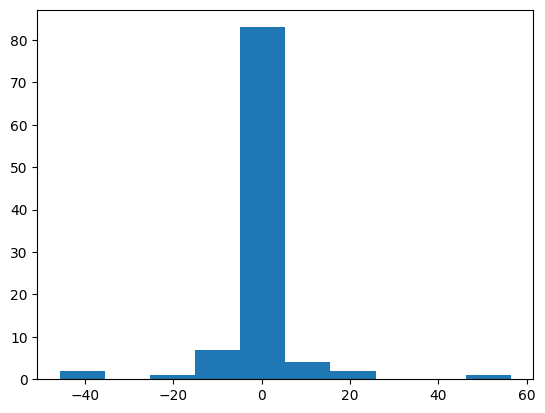

In [84]:
plt.hist(grad[0])

Text(0.5, 1.0, 'loss_landscape')

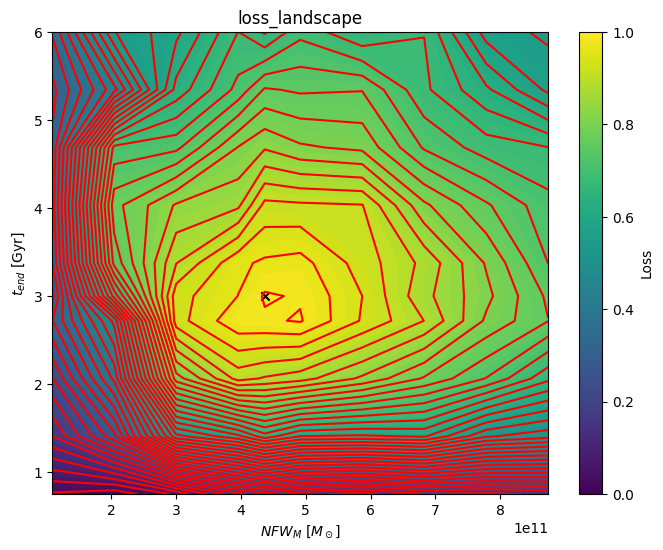

In [85]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = plt.contourf(10**M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=100, cmap="viridis")
plt.contour(ax, levels=ax.levels[::2], colors='r')
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="black", marker="x", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass_tend_20x20.pdf', dpi=300, bbox_inches='tight')

In [86]:
grad

(Array([ 5.70549304e-03,  2.11650338e-02,  2.90953480e-02,  4.52826768e-02,
         3.64197418e-02,  5.72904013e-02,  4.86480333e-02,  5.04492894e-02,
         5.41363955e-02,  6.40030205e-02,  9.41440184e-03,  1.05865330e-01,
         1.31988063e-01,  1.82851601e+00,  9.51710761e-01, -4.49319541e-01,
        -3.84622574e+01,  1.03140717e+01,  5.64007683e+01, -9.16773129e+00,
         2.59584077e-02, -1.01830959e+00, -7.74549901e-01,  2.72146910e-02,
         6.89002037e-01, -2.18954444e+00, -7.30141878e+00,  9.74801064e-01,
        -3.34146261e+00, -4.06072617e+00, -2.28414103e-01, -5.18451810e-01,
        -9.07189012e-01, -4.40638781e-01,  6.80839539e-01,  8.85778725e-01,
        -2.80700147e-01, -3.52654052e+00, -1.03658943e+01, -2.93834543e+00,
        -3.32024843e-01, -1.31076932e+00, -1.69303465e+00, -6.58286095e-01,
        -5.35259664e-01, -5.54788113e-01, -3.39674860e-01, -8.24236453e-01,
         8.83669472e+00,  2.35022297e+01, -2.56408900e-01, -8.15991998e-01,
        -5.9

In [87]:
grad[0].shape

(100,)

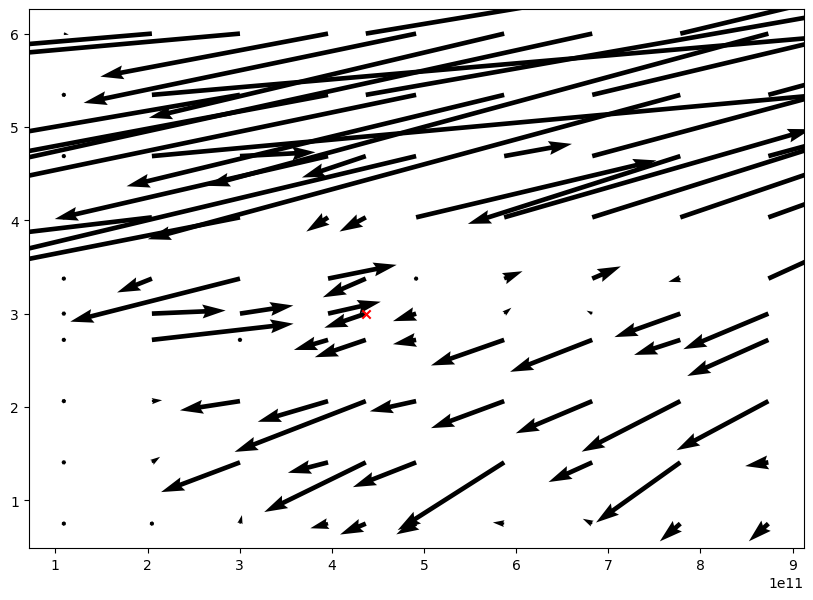

In [88]:
plt.style.use('default')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, )
vectorf_field = ax.quiver(10**M_tot_values*code_units.code_mass.to(u.Msun), 
                          t_end_values*code_units.code_time.to(u.Gyr),
                            grad[0].reshape(M_tot_grid.shape).T, 
                            grad[1].reshape(M_tot_grid.shape).T,
                            scale=10,)
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", marker="x", label="True values")


# Plummer scale radius

In [58]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

# @jit
def time_integration_Plummer_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    a=a
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0001])
   
    def log_diag_multivariate_normal(x, mean, sigma):
        """
        Log PDF of a multivariate Gaussian with diagonal covariance.
        
        Parameters
        ----------
        x : (D,)
        mean : (D,)
        sigma : (D,)  # standard deviations for each dimension
        """
        diff = (x - mean) / sigma
        D = x.shape[0]
        log_det = 2.0 * jnp.sum(jnp.log(sigma))
        norm_const = -0.5 * (D * jnp.log(2 * jnp.pi) + log_det)
        exponent = -0.5 * jnp.sum(diff**2)
        return norm_const + exponent

    def stream_likelihood_diag(model_stream, obs_stream, obs_errors, ):
        """
        Log-likelihood of observed stars given simulated stream (diagonal covariance).
        
        Parameters
        ----------
        model_stream : (N_model, D)
        obs_stream : (N_obs, D)
        obs_errors : (N_obs, D)   # per-dimension standard deviations
        tau : float
            Stream membership fraction
        p_field : float
            Background probability density
        """
        def obs_log_prob(obs, sigma):
            def model_log_prob(model_point):
                return log_diag_multivariate_normal(obs, model_point, sigma)

            # Compute log_probs for all model points
            log_probs = jax.vmap(model_log_prob)(model_stream)
            
            # Numerically stable average: log(mean(exp(log_probs)))
            log_p_stream = jax.scipy.special.logsumexp(log_probs) - jnp.log(model_stream.shape[0])
            
            # Mixture model
            # p_total = tau * jnp.exp(log_p_stream) + (1 - tau) * p_field
            p_total = jnp.exp(log_p_stream)
            return jnp.log(p_total + 1e-30)

        # Vectorize over observations
        logL_values = jax.vmap(obs_log_prob)(obs_stream, jnp.repeat(obs_errors, obs_stream.shape[0]).reshape(-1, 6))
        return jnp.mean(logL_values)/1_000
    
    return stream_likelihood_diag(model_stream=stream,
                             obs_stream=stream_target,
                             obs_errors=noise_std)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_a_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  



Gradient of the total mass of the Plummer:
 -8.984836
Loss:
 -0.030304013


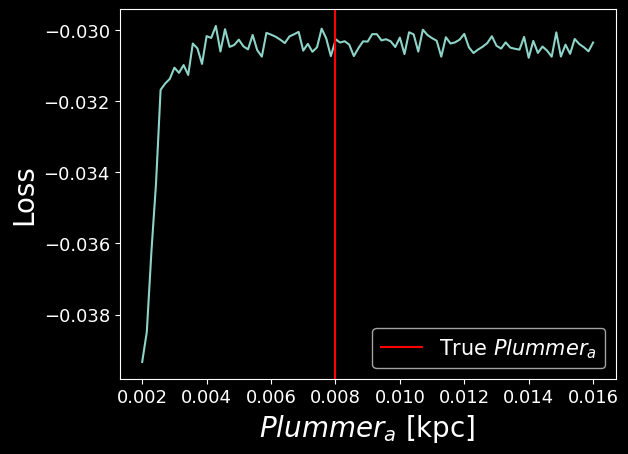

In [59]:
n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.Plummer_params.a*(1/4), params.Plummer_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.Plummer_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

a_sharded = a
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_Plummer_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.Plummer_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $Plummer_{a}$')
plt.xlabel("$Plummer_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()

(array([ 4., 14., 63., 14.,  0.,  3.,  1.,  0.,  0.,  1.]),
 array([-236.08050537, -136.79544067,  -37.51037598,   61.77468872,
         161.05975342,  260.34481812,  359.62988281,  458.91497803,
         558.20001221,  657.48504639,  756.7701416 ]),
 <BarContainer object of 10 artists>)

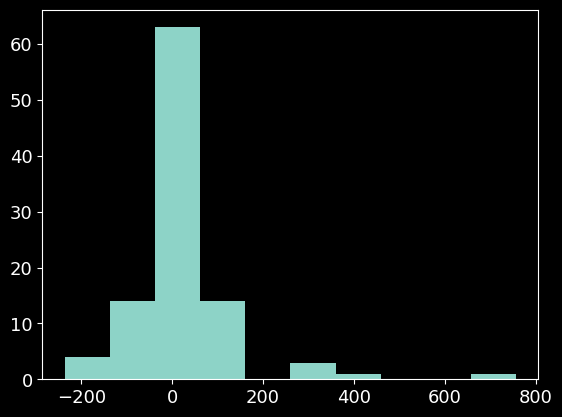

In [60]:
plt.hist(grad)

# Plummer mass

Since it is linked to the single star particle it needs lots of memory to compute


In [89]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


# @jit
def time_integration_Plummer_M_grad(Mtot, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    Mtot=Mtot
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    Mtot=Mtot 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return jnp.exp(-0.1 * (loss_js(dens_phi_target, dens_phi) +
            loss_js(dens_v_target, dens_v) +
            loss_js(dens_R_target, dens_R)))


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.Mtot*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_M_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  


Gradient of the total mass of the Plummer:
 -0.000980395
Loss:
 0.99397564


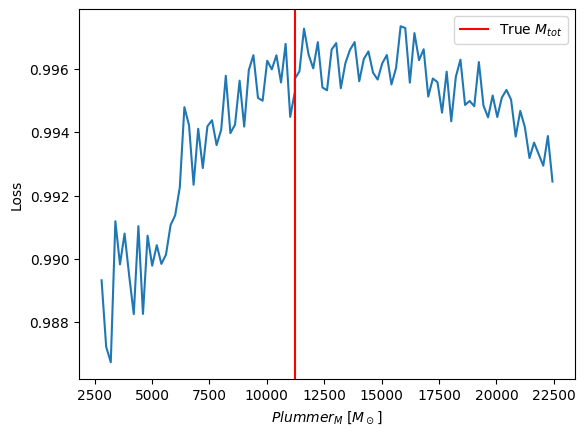

In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mtot = np.linspace(params.Plummer_params.Mtot*(1/4), params.Plummer_params.Mtot*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mtot = np.concatenate([Mtot, np.array([params.Plummer_params.Mtot])]) # Append the true Mvir value
Mtot = jnp.array(np.sort(Mtot))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mtot_sharded = jax.device_put(Mtot, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mtot_sharded = Mtot
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_M_grad_map(Mtot_and_key):
    Mtot, key = Mtot_and_key
    return jax.value_and_grad(time_integration_Plummer_M_grad)(Mtot, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_M_grad_map, 
    (Mtot_sharded, keys_sharded), 
    batch_size=3
)

plt.figure()
plt.plot(Mtot_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.Plummer_params.Mtot*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$Plummer_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()

(array([ 1.,  1.,  9., 23., 31., 24.,  8.,  2.,  0.,  1.]),
 array([-0.17390892, -0.13439202, -0.09487511, -0.05535821, -0.01584131,
         0.02367559,  0.0631925 ,  0.10270941,  0.14222631,  0.1817432 ,
         0.22126013]),
 <BarContainer object of 10 artists>)

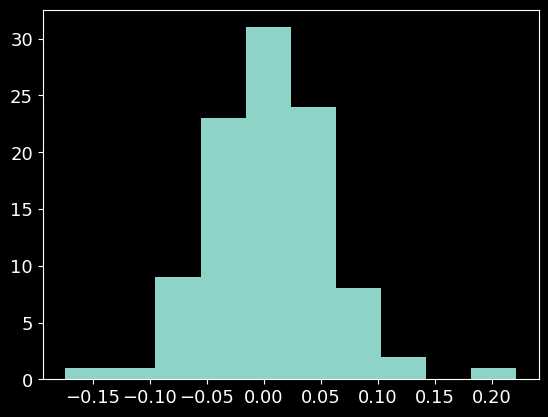

In [64]:
plt.hist(grad)

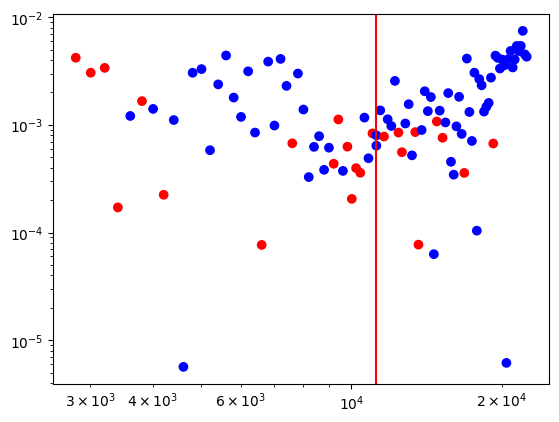

In [91]:
plt.scatter(Mtot_sharded*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.Plummer_params.Mtot*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

# Initial position Loss

In [80]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_xpos_grad(x_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    # take relevant projections from simulated stream
    x_phi = stream[:, [1,2]]   # phi1, phi2
    x_v   = stream[:, [4,5]]   # vphi1, vphi2
    x_R   = stream[:, [0,3]]   # R, v_radial

    # choose bandwidths (tune or use Silverman's rule)
    bw_phi = jnp.array([2.0, 0.5])     # example: phi1=2deg, phi2=0.5deg
    bw_v   = jnp.array([0.1, 0.01])    # example velocities
    bw_R   = jnp.array([0.5, 20.0])    # example R and vR

    # KDE densities on each meshgrid
    dens_phi = kde2d_on_grid(x_phi, PHI1, PHI2, bw_phi)
    dens_v   = kde2d_on_grid(x_v, V1, V2, bw_v)
    dens_R   = kde2d_on_grid(x_R, R_GRID, VR_GRID, bw_R)

    # return (jnp.sum((dens_phi - dens_phi_target)**2) +
    #         jnp.sum((dens_v - dens_v_target)**2) +
    #         jnp.sum((dens_R - dens_R_target)**2))

    return jnp.exp(-0.1 * (loss_js(dens_phi_target, dens_phi) +
            loss_js(dens_v_target, dens_v) +
            loss_js(dens_R_target, dens_R)))
    

# Utility: ensure non-neg and avoid zeros
@jit
def _safe(d, eps=1e-12):
    return jnp.clip(d, a_min=eps)


@jit
def loss_js(d_target, d_sim):
    p = _safe(d_target) / jnp.sum(_safe(d_target))
    q = _safe(d_sim)   / jnp.sum(_safe(d_sim))
    m = 0.5 * (p + q)
    return 0.5 * (jnp.sum(p * (jnp.log(p) - jnp.log(m))) + jnp.sum(q * (jnp.log(q) - jnp.log(m))))


@jit
def kde2d_on_grid(x, grid_x, grid_y, bandwidth):
    """
    Evaluate 2D Gaussian KDE on a meshgrid.

    Parameters
    ----------
    x : (N, 2) 
        Simulation data points in 2D (e.g., (phi1, phi2)).
    grid_x, grid_y : (Nx, Ny)
        Meshgrid arrays defining grid coordinates where density is evaluated.
    bandwidth : float or (2,)
        Bandwidth per dimension (std dev of Gaussian kernel).

    Returns
    -------
    dens : (Nx, Ny) 
        KDE density evaluated at grid points.
    """
    N, d = x.shape
    assert d == 2

    # Flatten grid to (G, 2)
    grid_points = jnp.stack([grid_x.ravel(), grid_y.ravel()], axis=1)  # (G,2)

    # Differences (G, N, 2)
    diff = grid_points[:, None, :] - x[None, :, :]

    # Handle bandwidth
    bw = jnp.atleast_1d(bandwidth)
    if bw.shape == (1,):
        bw = jnp.repeat(bw, 2)
    var = bw**2

    # Mahalanobis distance per dimension
    sq = (diff**2) / var  # (G,N,2)

    # log kernel for each (gridpoint, datapoint)
    logk = -0.5 * jnp.sum(sq, axis=-1) - 0.5*jnp.sum(jnp.log(2*jnp.pi*var))

    # logsumexp over datapoints
    log_dens = logsumexp(logk, axis=1) - jnp.log(N)

    dens = jnp.exp(log_dens).reshape(grid_x.shape)
    return dens

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 10.0 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xpos_grad, )(x_pos, key)
print("Gradient of the x position of the center of mass:\n", grad)
print("Loss:\n", loss)

Gradient of the x position of the center of mass:
 29.558146
Loss:
 0.86166525


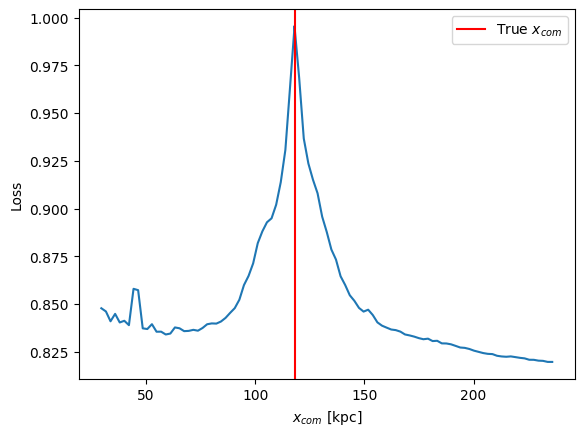

In [81]:
n_sim = 99
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
x_pos = jnp.array(np.sort(x_pos))
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_xpos_grad_map(x_pos_and_key):
    x_pos, key = x_pos_and_key
    return jax.value_and_grad(time_integration_xpos_grad)(x_pos, key)
loss, grad = jax.lax.map(
    time_integration_xpos_grad_map, 
    (x_pos_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(x_pos_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(11.8*(code_units.code_length).to(u.kpc), color='r', label='True $x_{com}$')
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel('Loss')
plt.legend()


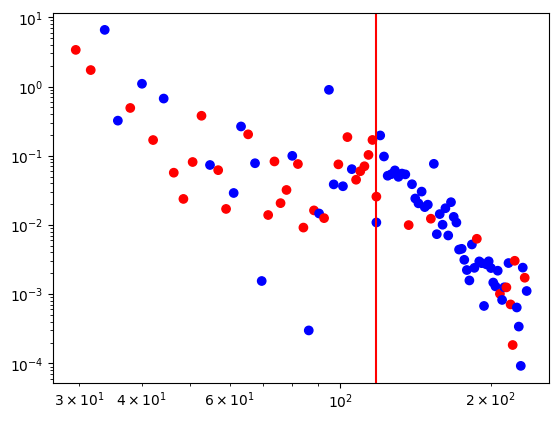

In [82]:
plt.scatter(x_pos_sharded*(code_units.code_length).to(u.kpc), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(11.8*(code_units.code_length).to(u.kpc), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')

In [15]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_xy_grad(x_pos, y_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, y_pos, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 11.8 * u.kpc.to(code_units.code_length)
y_pos = 0.79 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xy_grad, )(x_pos, y_pos, key)
print("Gradient of the x and y position of the center of mass:\n", grad)
print("Loss:\n", loss)


Gradient of the x and y position of the center of mass:
 3943013.2
Loss:
 0.4485926


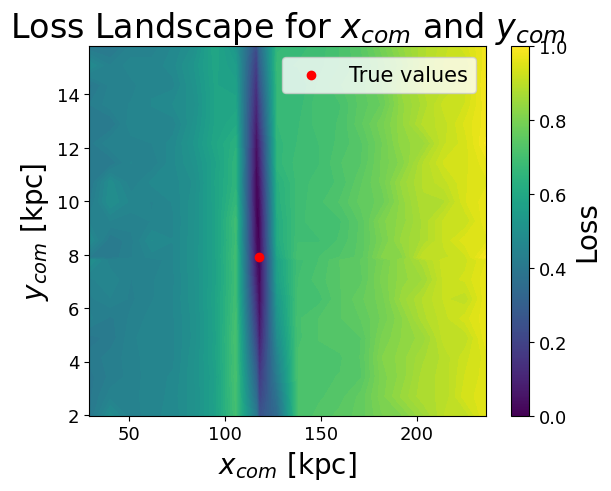

In [16]:
n_sim = 20
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
y_pos = np.linspace(0.79*(1/4), 0.79*(8/4), n_sim)

x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
y_pos = np.concatenate([y_pos, np.array([0.79])])  # Append the true y position value
x_pos = jnp.array(np.sort(x_pos))
y_pos = jnp.array(np.sort(y_pos))

xx, yy = jnp.meshgrid(x_pos, y_pos, indexing="ij")
# Flatten the grid for vectorized computation
x_pos_flat = xx.flatten()
y_pos_flat = yy.flatten()
keys_flat = jnp.arange(len(x_pos_flat))  # Create a flat array of keys
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
y_pos_sharded = jax.device_put(y_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))
@jit
def time_integration_xy_grad_map(xy_and_key):
    x_pos, y_pos, key = xy_and_key
    return jax.value_and_grad(time_integration_xy_grad)(x_pos, y_pos, key)
loss, grad = jax.lax.map(
    time_integration_xy_grad_map, 
    (x_pos_sharded, y_pos_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.contourf(xx*(code_units.code_length).to(u.kpc), 
             yy*(code_units.code_length).to(u.kpc), 
             loss.reshape(xx.shape), levels=100, cmap="viridis")
plt.scatter(11.8*(code_units.code_length).to(u.kpc), 0.79*(code_units.code_length).to(u.kpc), color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel("$y_{com}$ [kpc]")
plt.title("Loss Landscape for $x_{com}$ and $y_{com}$")
plt.legend()

# Initial Velocity Loss

In [17]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_vx_grad(vx_com, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[vx_com,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
vx_com = 109.5 * (3/4) * (u.km/u.s).to(code_units.code_velocity)
key = 0
loss, grad = jax.value_and_grad(time_integration_vx_grad, )(vx_com, key)
print("Gradient of the x velocity of the center of mass:\n", grad)

Gradient of the x velocity of the center of mass:
 -0.0015706393


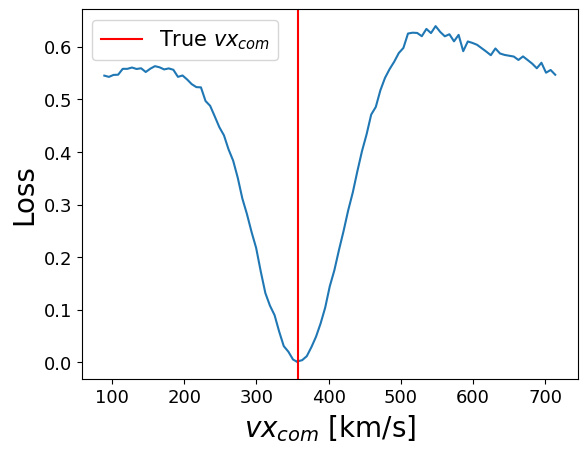

In [18]:
n_sim = 99
keys = jnp.arange(n_sim+1)
vx_com = np.linspace(109.5*(1/4), 109.5*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
vx_com = np.concatenate([vx_com, np.array([109.5])])  # Append the true vx_com value
vx_com = jnp.array(np.sort(vx_com))
mesh = Mesh(np.array(jax.devices()), ("i",))
vx_com_sharded = jax.device_put(vx_com, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

@jit
def time_integration_vx_grad_map(vx_com_and_key):
    vx_com, key = vx_com_and_key
    return jax.value_and_grad(time_integration_vx_grad)(vx_com, key)
loss, grad = jax.lax.map(
    time_integration_vx_grad_map, 
    (vx_com_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(vx_com_sharded*(code_units.code_velocity).to(u.km/u.s), loss)
plt.axvline(109.5*(code_units.code_velocity).to(u.km/u.s), color='r', label='True $vx_{com}$')
plt.xlabel("$vx_{com}$ [km/s]")
plt.ylabel('Loss')
plt.legend()